Para poder hacer uso de la API primero hay que registrarse en el siguiente enlace: https://opendata.nationalrail.co.uk/user

Una vez activada la cuenta tenemos que habilitar LDBWS (Live Departure Boards Web Service) en el siguiente enlace: https://realtime.nationalrail.co.uk/OpenLDBWSRegistration

Tras verificar el registro, podremos obtener el token como en la siguiente imagen:

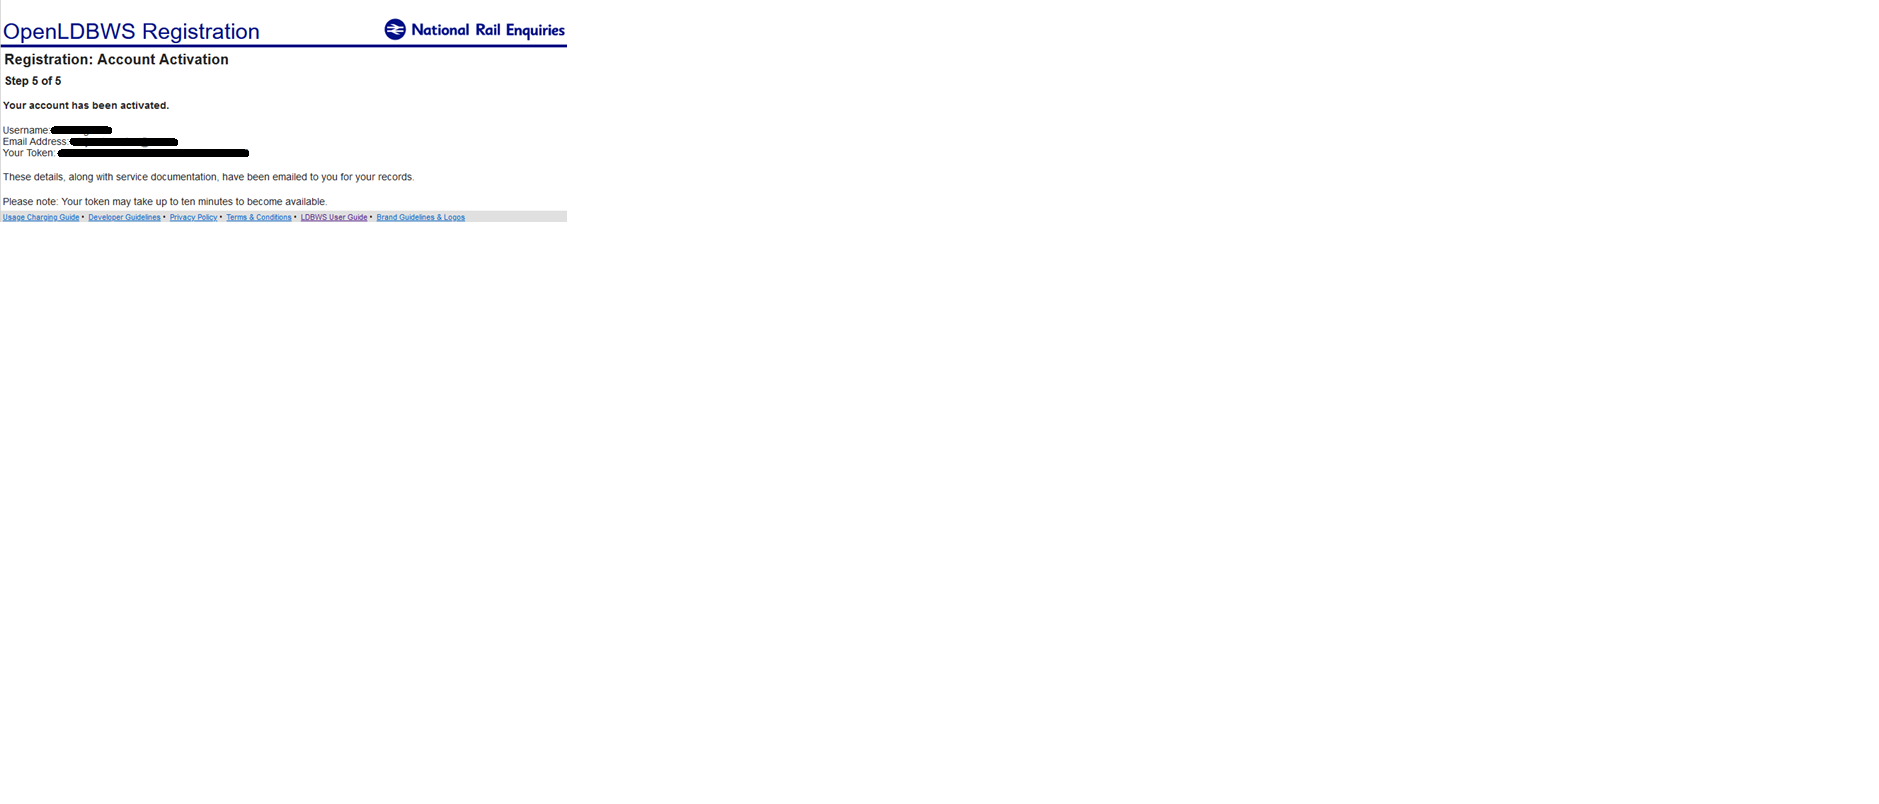

API en el siguiente enlace: https://lite.realtime.nationalrail.co.uk/OpenLDBWS/

Empezaremos fijandonos en los servicios que tenemos disponibles (Supported Operations). Si hacemos click en cualquiera de ellos se nos desplegara los parametros que recibe y la respuesta que ofrece.

Por centralizar, vamos a empezar por el metodo "GetDepartureBoard" y en los parametros que recibe y que funcionalidad ofrecen. Aunque todos los métodos disponibles ofrecen prácticamente los mismos parámetros.

Una vez entendido los parametros, fijate que el método devuelve:
Response
A StationBoard object containing the requested details.

Más abajo podemos encontrar la categoría "Objects" donde podemos encontrar el objeto StationBoard que devuelve el metodo GetDepartureBoard. Por simplificar, accederemos al elemento del objeto "trainServices", la que como se indica, contiene ServiceItem object. Si desplegamos ServiceItem, podremos ver a que información podemos acceder.

Una vez tenemos una idea de como funciona la API y la información que tenemos disponible, es momento de empezar con el código.


Para los que usan anaconda deben de instalar la libreria zeep mediante linea de comandos (pip install zeep>=4.1.0), e importaremos los siguientes métodos. Si tienes curiosidad, puedes leer más sobre zeep en: https://docs.python-zeep.org/en/master/, aunque a modo de resumen es un cliente SOAP (Simple Object Access Protocol) que nos permite el intercambio de información mediante el protocolo WSDL (Web Service Description Language), el cual se utiliza para describir servicios basados en XML.

In [1]:
#!pip install zeep>=4.1.0
from zeep import Client, Settings, xsd
from zeep.plugins import HistoryPlugin

Para no abrumar, vamos a empezar poco a poco, en primer lugar vamos a definir lo necesario para poder realizar la conexión. Introduce el token que te proporcionaron en la variable LDB_TOKEN. Ademas, se definen algunas variables necesarias para el cliente, asi como se le especifica el tipo de conexión. Puedes consultar el detalle de lo que hacen estos métodos en la documentación de zeep (https://docs.python-zeep.org/en/master/index.html).

In [2]:
#Introduce el token obtenido en el paso anterior
LDB_TOKEN = 'b7b0517f-8dcc-4193-be54-377840fed088'
WSDL = 'http://lite.realtime.nationalrail.co.uk/OpenLDBWS/wsdl.aspx?ver=2021-11-01'

if LDB_TOKEN == '':
    raise Exception("Please configure your OpenLDBWS token!")

settings = Settings(strict=False)

history = HistoryPlugin()

client = Client(wsdl=WSDL, settings=settings, plugins=[history])

header = xsd.Element(
    '{http://thalesgroup.com/RTTI/2013-11-28/Token/types}AccessToken',
    xsd.ComplexType([
        xsd.Element(
            '{http://thalesgroup.com/RTTI/2013-11-28/Token/types}TokenValue',
            xsd.String()),
    ])
)
header_value = header(TokenValue=LDB_TOKEN)

print("Configuration done!")

Configuration done!


Hacemos la petición usando el método "GetDepartureBoard". En mi caso, le voy a pedir 100 filas (aunque no tiene tantas salidas, el número de "salidas" programadas en el espacio de tiempo que podemos indicarle (máximo 120 minutos), puede variar en función del momento del día.

In [3]:
respuesta = client.service.GetDepartureBoard(numRows=50, crs='EUS', _soapheaders=[header_value])

Antes de presentar la información, vamos a explorar que nos devuelve (o contiene) la variable res. Tal y como se indico anteriormente nos vamos a centrar en el atributo "trainServices", que es un objeto de tipo "ServiceItem".

In [4]:
print(respuesta.trainServices)

{
    'service': [
        {
            'sta': None,
            'eta': None,
            'std': '15:00',
            'etd': 'On time',
            'platform': None,
            'operator': 'London Overground',
            'operatorCode': 'LO',
            'isCircularRoute': None,
            'isCancelled': None,
            'filterLocationCancelled': None,
            'serviceType': 'train',
            'length': None,
            'detachFront': None,
            'isReverseFormation': None,
            'cancelReason': None,
            'delayReason': None,
            'serviceID': '2016118EUSTON__',
            'adhocAlerts': None,
            'rsid': None,
            'origin': {
                'location': [
                    {
                        'locationName': 'London Euston',
                        'crs': 'EUS',
                        'via': None,
                        'futureChangeTo': None,
                        'assocIsCancelled': None
                    }
     

Como has podido observar, contiene el atributo "service" el cual es un array con la información, donde cada posición del vector contiene la información de una salida de un tren. Vamos a visualizar la primera posición del array.

In [5]:
servicios = respuesta.trainServices.service

tren = servicios[1]
print(tren)
print("Horario: " + tren.std + " Hacia " + tren.destination.location[0].locationName + " - " + "Estado: " + tren.etd)

{
    'sta': None,
    'eta': None,
    'std': '15:09',
    'etd': 'On time',
    'platform': None,
    'operator': 'West Midlands Trains',
    'operatorCode': 'LM',
    'isCircularRoute': None,
    'isCancelled': None,
    'filterLocationCancelled': None,
    'serviceType': 'train',
    'length': None,
    'detachFront': None,
    'isReverseFormation': None,
    'cancelReason': None,
    'delayReason': None,
    'serviceID': '2023227EUSTON__',
    'adhocAlerts': None,
    'rsid': None,
    'origin': {
        'location': [
            {
                'locationName': 'London Euston',
                'crs': 'EUS',
                'via': None,
                'futureChangeTo': None,
                'assocIsCancelled': None
            }
        ]
    },
    'destination': {
        'location': [
            {
                'locationName': 'Milton Keynes Central',
                'crs': 'MKC',
                'via': None,
                'futureChangeTo': None,
                'assocI

Ahora que hemos visto, la información de una salida, vamos a preparar código para obtener información de los trenes que salen de la estación "London Euston". La API utiliza el parámetro CRS para hacer mención a las diferentes estaciones. Este es un sistema antiguo que sacaron en 1979, y aunque han aparecido nuevos códigos, es el que sigue utilizando la API. Puedes descargar [aquí](https://www.rail-record.co.uk/railway-location-codes/) el excel con todos los CRS (y otras codificaciones).

Aunque para la práctica vamos a simplificar esta parte, por lo que podeis acceder a https://www.nationalrail.co.uk/ y empezar a escribir el nombre de una ciudad para que os salga la ciudad y el código CRC al que podeis hacer referencia en el método o seguir utilizando EUS (London Euston) como en el ejemplo anterior.

Vamos a realizar de nuevo la petición al metodo GetDepartureBoard, a la estación EUS, con 100 filas y una ventana de tiempo de 120 minutos.

In [6]:
respuesta = client.service.GetDepartureBoard(numRows=100, crs='EUS', timeWindow = 120, _soapheaders=[header_value])

Una vez hecha la petición vamos a recorrer la variable "res.trainServices.service". Debemos de imprimir por pantalla la hora de salida, el destino y el estado del servicio (cancelado, retrasado, o En hora).

In [7]:
servicios = respuesta.trainServices.service

#print(servicios)

i = 0
while i < len(servicios):
    tren = servicios[i]
    print("Salida " + tren.std + " Hacia " + tren.destination.location[0].locationName + ", estado: " + tren.etd)
    i += 1

Salida 15:00 Hacia Watford Junction, estado: On time
Salida 15:09 Hacia Milton Keynes Central, estado: On time
Salida 15:13 Hacia Manchester Piccadilly, estado: On time
Salida 15:15 Hacia Watford Junction, estado: On time
Salida 15:16 Hacia Glasgow Central, estado: On time
Salida 15:23 Hacia Birmingham New Street, estado: On time
Salida 15:24 Hacia Tring, estado: On time
Salida 15:30 Hacia Glasgow Central, estado: Cancelled
Salida 15:30 Hacia Watford Junction, estado: On time
Salida 15:33 Hacia Manchester Piccadilly, estado: On time
Salida 15:39 Hacia Milton Keynes Central, estado: On time
Salida 15:40 Hacia Birmingham New Street, estado: On time
Salida 15:43 Hacia Liverpool Lime Street, estado: On time
Salida 15:45 Hacia Watford Junction, estado: On time
Salida 15:46 Hacia Crewe, estado: On time
Salida 15:53 Hacia Manchester Piccadilly, estado: On time
Salida 15:54 Hacia Tring, estado: On time
Salida 15:56 Hacia Birmingham New Street, estado: On time
Salida 16:00 Hacia Watford Junctio

Realiza lo mismo que en el caso anterior, pero ahora captura los trenes de llegada(arrival) a la estación de London Euston (EUS). Si quieres puedes usar cualquier otra estación.

In [8]:
respuesta_llegada = client.service.GetArrivalBoard(numRows=100, crs='EUS', timeWindow = 120, _soapheaders=[header_value])
servicios_llegada = respuesta_llegada.trainServices.service

#print(servicios_llegada[1])

#Manejo de excepciones ya que tren.eta en ocasiones aparece como hora y en ocasiones como estado (On time)


i = 0
while i < len(servicios_llegada):
    try:
        tren = servicios_llegada[i]
        print("Hora llegada " + str(tren.eta) + " a " + str(tren.destination.location[0].locationName) + ", plataforma: " + str(tren.platform))
    except Exception as e:
        print(f"Se encontró un error con el tren en el índice {i}: {e}")
    finally:
        i += 1

Hora llegada 15:41 a London Euston, plataforma: 3
Hora llegada 14:59 a London Euston, plataforma: None
Hora llegada 15:19 a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada Cancelled a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada 15:20 a London Euston, plataforma: None
Hora llegada 15:21 a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada 15:26 a London Euston, plataforma: None
Hora llegada 15:30 a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada Cancelled a London Euston, plataforma: None
Hora llegada On time a London Euston, plataforma: None
Hora llegada On time a 